In [1]:
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

df = pd.read_csv("/content/drive/MyDrive/wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [2]:
df.date = pd.to_datetime(df.date)
plotly_df(df.set_index("date")[["count"]])

# сезонность примерно 5-7 дней

In [3]:
!pip install prophet

In [4]:
from prophet import Prophet

predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

In [5]:
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgp5p_rsb/jm0x0_ss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgp5p_rsb/4zxo416b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61768', 'data', 'file=/tmp/tmpgp5p_rsb/jm0x0_ss.json', 'init=/tmp/tmpgp5p_rsb/4zxo416b.json', 'output', 'file=/tmp/tmpgp5p_rsb/prophet_modelrhwc_zbf/prophet_model-20241120075144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


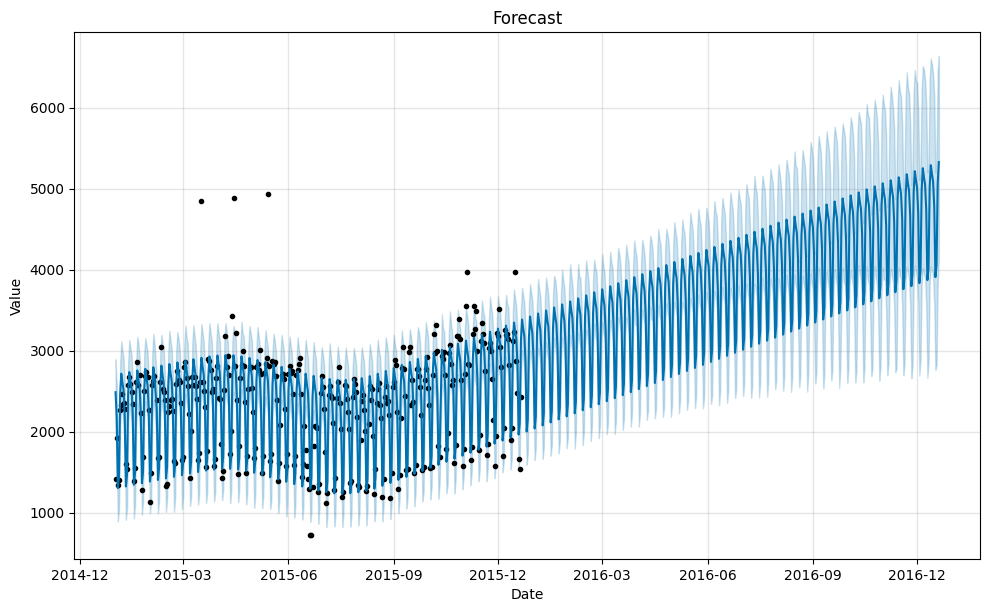

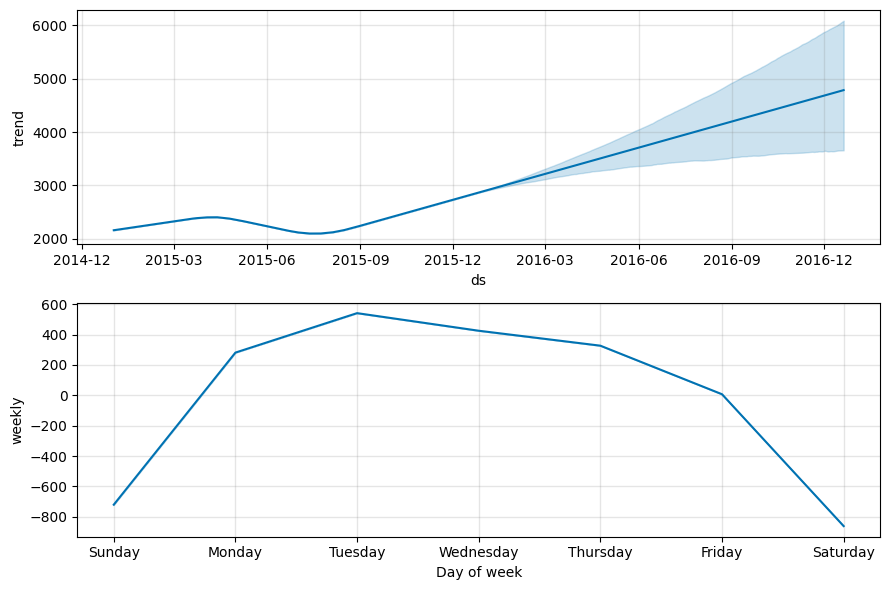

In [6]:
import matplotlib.pyplot as plt
future = model.make_future_dataframe(periods=365)
# Прогнозирование
forecast = model.predict(future)
# Построение графика прогноза
fig = model.plot(forecast)
plt.title('Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Построение графика компонентов прогноза
fig = model.plot_components(forecast)
plt.show()


In [7]:
model = Prophet()
model.fit(train_df)

# Создание датафрейма для прогноза
future = model.make_future_dataframe(periods=predictions)

# Прогнозирование
forecast = model.predict(future)

# Получение предсказания на 20 января
forecast_20_jan = forecast[forecast['ds'] == '2016-01-20']
predicted_value = forecast_20_jan['yhat'].values[0]
print(f"Предсказание на 20 января: {round(predicted_value)}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgp5p_rsb/lkzpk4x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgp5p_rsb/axpa2ukz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11659', 'data', 'file=/tmp/tmpgp5p_rsb/lkzpk4x0.json', 'init=/tmp/tmpgp5p_rsb/axpa2ukz.json', 'output', 'file=/tmp/tmpgp5p_rsb/prophet_modeln73a0fw_/prophet_model-20241120075147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Предсказание на 20 января: 3422


In [8]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

actual = df[-predictions:]['y'].values

predicted = forecast[-predictions:]['yhat'].values

mape = mean_absolute_percentage_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")



MAPE: 0.3434570128132223
MAE: 596.5328223327066


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'])
p_value = result[1]
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Ряд стационарен")
else:
    print("Ряд нестационарен")


p-value: 0.015383668419468997
Ряд стационарен


In [13]:
import itertools
import statsmodels.api as sm
import warnings

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")

# Ваш код здесь

# Функция для поиска лучших параметров
def find_best_sarimax_params(data, seasonal_order):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_order) for x in pdq]

    best_aic = float('inf')
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue
    return best_params, best_aic

seasonal_order = 7
best_params, best_aic = find_best_sarimax_params(df['y'], seasonal_order)
print(f"Лучшие параметры: {best_params}")
print(f"Лучший AIC: {best_aic}")


Лучшие параметры: ((1, 1, 1), (0, 1, 1, 7))
Лучший AIC: 5349.930335219492


In [15]:
df

,ds,y
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264
...,...,...
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
